# Measuring SNR of an Audio Sample

In order to quantify our demodulator, we need to measure the SNR of
baseband signals.

If we don't have a pristine copy of the baseband, we have to estimate
the noise by finding pure noise, one completely free of the signal,
either in the time domain or in the frequency domain to use as a base
for the noise estimate.

This post discusses one way to do this.

https://dsp.stackexchange.com/questions/35403/calculate-the-snr-of-wav-file

This is the formula that they suggest.

$ SNR=\frac{P(signal)+P(noise)-P(noise)}{P(noise)} $

For M17, the 4-FSK baseband is restricted to 3500Hz and below.  Here the spectrum
of a -121dBm signal from a vector signal generator into an RTL SDR running `rtl_fm`.

![M17 Baseband](m17-baseband-spectrum.png)

Beyond the roll-off, there is channel noise.  What we really want to measure
is the noise after the roll-off.  And for that we can use a DFT. For this we will
use a sliding DFT implementation used elsewhere for data carrier detection.

We will be using the NSlidingDFT, which allows us to compute N DFTs in parallel.
We will then compute the mean of each frequency bin, giving the average power in
each bin.  The DFT will have a resolution bandwidth (RBW) of 500Hz.

In [1]:
%pylab inline

import cmath
import numpy as np
import scipy.io.wavfile
from scipy.signal import firwin, lfilter, lfilter_zi

class NSlidingDFT:
    
    PI2 = cmath.pi * 2.0

    def _make_coeff(self, sample_rate, freq):
        assert(freq <= sample_rate // 2)
        k = freq / sample_rate
        return cmath.exp(- 1j * self.PI2 * k)
        
    def __init__(self, sample_rate, frequencies, bin_size = 1000):
        
        self._sample_rate = sample_rate
        self._coeffs = [self._make_coeff(sample_rate, f) for f in frequencies]
        self._history = np.zeros(int(sample_rate / bin_size))
        self._index = 0
        self._results = np.zeros(len(self._coeffs), dtype = complex)
    
    def __call__(self, sample):
        
        index = self._index
        self._index += 1
        if self._index == len(self._history):
            self._index = 0
        delta = (sample - self._history[index])
        for i in range(len(self._coeffs)):
            self._results[i] = (self._results[i] + delta) * self._coeffs[i]
        self._history[index] = sample
        return self._results

Populating the interactive namespace from numpy and matplotlib


## Plotting Functions

We are going to define a few convenience functions which will allow us
to plot graphs in the time domain and in the frequency domain.

In [2]:
def plot_to_notebook(samples, sample_rate, legend = [], lines = ['-'], props = None):
    
    duration = len(samples) / sample_rate
    t = np.linspace(0, duration, len(samples), endpoint=True)
    plt.figure()
    plt.rcParams['figure.figsize'] = [8, 4]
    ax = plt.subplot(1, 1, 1)
    if props is not None: ax.set_prop_cycle(props)
    plt.xlabel('Time (sec)')
    plt.locator_params(axis='y', nbins=8)
    plt.grid()
    plt.xticks(np.arange(0, duration, 10.0/sample_rate), rotation=45)
    try:
        if len(samples[0]) > 1:
            lines = lines * len(samples[0])
            for i in range(len(samples[0])):
                plt.plot(t, [x[i] for i in samples], lines[i])
        else:
            plt.plot(t, samples, lines[0])
    except:
        plt.plot(t, samples, lines[0])

    plt.legend(legend)

def plot_spectrum(spectrums, max_freq, legend = []):
    
    # Number of samplepoints
    N = len(spectrums[0])
    # sample spacing
    T = 1.0 / max_freq
    x = np.linspace(0.0, N*T, N)
    y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
    xf = np.linspace(0.0, 1.0/T, N)
    plt.rcParams['figure.figsize'] = [8, 4]
    fig, ax = plt.subplots()
    for spectrum in spectrums:
        ax.plot(xf, 10*np.log10(1.0/N * spectrum))
    plt.legend(legend)

## SNR to Eb/N0

We will need to convert the SNR value to Eb/NO (energy per bit to noise power
spectral density ratio).  The formula for this is:

$ E_b/N_0 = {SNR}{\frac{B_{Hz}}{f_b}} $

Where $f_b$ is the information rate and $B_{Hz}$ is the channel bandwidth.

For M17, we have a $B_{Hz}$ of roughly 8900Hz.  The information rate, $ f_b $,
is a little more difficult.  The information rate of each of the frame types,
the link setup frame, the audio stream frame, the packet frame, and the LICH,
are all different.  We are going to focus on just the audio frame for now.

The audio frame use a punctured 1:2 convolutional code to acheive a rate 6:11.
at 9600 bits per second, that equates to an $ f_b $ of 5236.

## Analysis

We are now going to measure a file -- the same file from the plot above.

Note that there are files with captured at 120-123dBm, inclusive in the
directory.  You can just change the dBm value in the filename to
analyze those files.

We will plot the averaged power density.

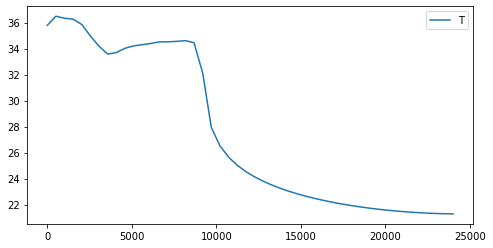

In [3]:
CHUNK_SIZE=960

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def compute_snr(samples, max_frequency = 24000):
    """Compute the spectrum from 0 to max_frequency.  Return
    the spectrum (500Hz RBW), the SNR and Eb/N0 for M17 stream."""
    
    spectrum = NSlidingDFT(48000, range(0, max_frequency, 500), 500)
    s = np.array([np.abs(spectrum(sample)) for sample in samples])
    var = np.var(s, axis = 0)

    m = [np.mean(x, axis=0) for x in chunker(s, CHUNK_SIZE)]
    ms = np.mean(m, axis=0)

    ms_sig = np.mean(var[0:7])
    ms_noi = np.mean(var[7:])
    snr = 10 * np.log10((np.sqrt(ms_sig) - np.sqrt(ms_noi)) / np.sqrt(ms_noi))
    EbN0 = snr * (8900.0 / 5236.0)
    return ms, snr, EbN0

sample_rate, baseband = scipy.io.wavfile.read('test-121dBm.wav')

baseband = baseband[96000:48000*7]

ms, snr, EbN0 = compute_snr(baseband, 24000)

plot_spectrum([ms], 24000, 'Test 121dBm')

Here is the computed SNR and Eb/N0

In [4]:
print(f'SNR = {snr:3.2f}, Eb/N0 = {EbN0:3.2f}dB')

SNR = 2.43, Eb/N0 = 4.12dB


## Simulation

We need to show that the above works properly by taking a pure baseband signal and adding
AWGN to it.  This will give us a known SNR value and allows us to verify that the above
SNR analysis is correct.

To do that we define functions that will add AWGN to an M17 baseband file to acheive a
specified SNR.

 - https://stackoverflow.com/questions/52913749/add-random-noise-with-specific-snr-to-a-signal
 - https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python
 - https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb8

In [5]:
def add_awgn(signal, SNR_dB):
    """Add noise to a signal to acheive the specified SNR (in dB), returning the
    noisy signal and the noise that was added to the signal."""
    
    snr = 10.0**(SNR_dB/10.0)
    power = signal.var()
    noise = np.random.normal(0, np.sqrt(power / snr), len(signal))
    return signal+noise, noise

def load_noisy(filename, SNR_dB):
    """Returns the sample rate of the file, the signal plust noise, and the noise
    that was added to the signal."""
    
    sample_rate, baseband_data = scipy.io.wavfile.read(filename)
    baseband_data = np.array(baseband_data, dtype=float)
    return sample_rate, *add_awgn(baseband_data, SNR_dB)

Let's load a file with 6dB of AWGN and plot the clean and noisy versions of the waveform.

The file we are using was created by taking the raw baseband output from `m17-mod` and
converting it to a WAV file.  It is as noise-free as possible.

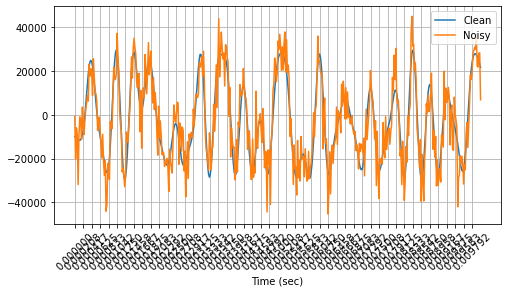

In [6]:
sps, clean = scipy.io.wavfile.read('m17-brain.wav')
clean = np.array(clean, dtype=float)
noisy_brain, noise = add_awgn(clean, 6.0)
scipy.io.wavfile.write('m17-brain-6dB.wav', sps, np.array(
    np.concatenate([noise * 2, noisy_brain * .75]), dtype=np.int16))

plot_to_notebook(list(zip(clean[4000:4480], noisy_brain[4000:4480])), 48000, ['Clean', 'Noisy'])

And now let's analyze the file, plot the spectrum and show the SNR and Eb/N0.

The computation may take some time.

In [7]:
ms, snr, EbN0 = compute_snr(noisy_brain, 24000)

SNR = 6.55, Eb/N0 = 11.13dB


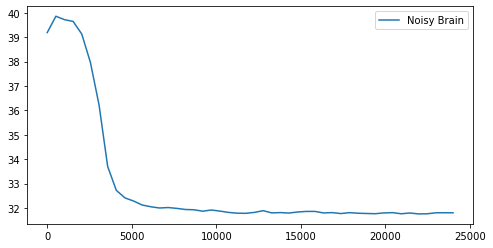

In [8]:
plot_spectrum([ms], 24000, ['Noisy Brain'])
print(f'SNR = {snr:3.2f}, Eb/N0 = {EbN0:3.2f}dB')

Let's try a few more to see if the results hold up.

SNR = 4.87, Eb/N0 = 8.27dB


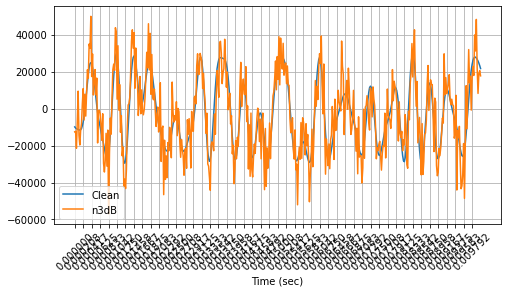

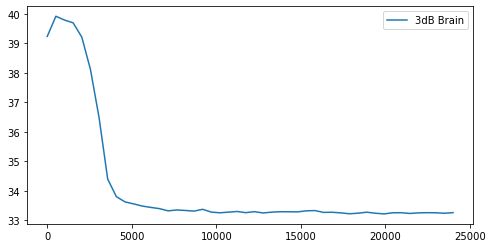

In [9]:
sps, n3dB, noise = load_noisy('m17-brain.wav', 3.0)
ms, snr, EbN0 = compute_snr(n3dB, 24000)
plot_to_notebook(list(zip(n3dB[4000:4480] - noise[4000:4480], n3dB[4000:4480])), 48000, ['Clean', 'n3dB'])
plot_spectrum([ms], 24000, ['3dB Brain'])
print(f'SNR = {snr:3.2f}, Eb/N0 = {EbN0:3.2f}dB')

It would appear that these estimates do not work at low SNR, or the code for adding AWGN to a specified SNR do not work.  Let's try a higher SNR.

SNR = 9.34, Eb/N0 = 15.87dB


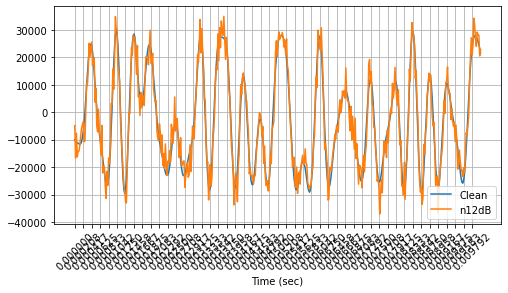

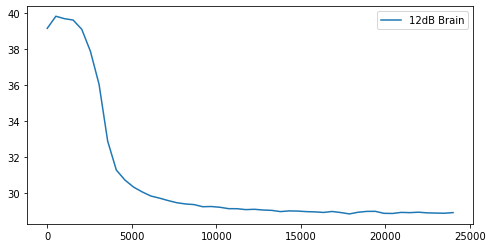

In [10]:
sps, n12dB, noise = load_noisy('m17-brain.wav', 12.0)
ms, snr, EbN0 = compute_snr(n12dB, 24000)
plot_to_notebook(list(zip(n12dB[4000:4480] - noise[4000:4480], n12dB[4000:4480])), 48000, ['Clean', 'n12dB'])
plot_spectrum([ms], 24000, ['12dB Brain'])
print(f'SNR = {snr:3.2f}, Eb/N0 = {EbN0:3.2f}dB')

# Summary

This shows that the measurement of SNR, if the AWGN code is accurate, does not work properly.

For a 6dB signal, we get an approximately correct answer, but for 3dB, we measure 4.87dB,
and for a signal with 12dB SNR, we measure 9.34dB.